[[0.00181153 0.00446869 0.0043455  ... 0.08018766 0.06326606 0.05611176]
 [0.00855306 0.00588494 0.00597607 ... 0.09874316 0.07960271 0.05917354]
 [0.00369711 0.00366017 0.00397463 ... 0.11788391 0.10012495 0.07233512]
 ...
 [0.00383974 0.00212836 0.00790006 ... 0.07489431 0.04707305 0.03796269]
 [0.00639997 0.00753572 0.00731954 ... 0.07633846 0.05632284 0.04128511]
 [0.00269716 0.00738604 0.0059346  ... 0.07046476 0.0579988  0.03629601]]
[Input  #45] aligned to Target (count=6 vs 1):
  ↔ Target #1: src value=0.531988, coord=(y=62, x=51), Δvalue=-0.161159 (-23.3%), dist=1.414 (1.56%)
  Unmatched src: #1, #3, #4, #5, #6
[Gen    #45] aligned to Target (count=1 vs 1):
  ↔ Target #1: src value=0.709428, coord=(y=61, x=50), Δvalue=0.016281 (+2.3%), dist=0.000 (0.00%)
[Target #45] count=1 peaks:
  #1: value=0.693147, coord=(y=61, x=50)


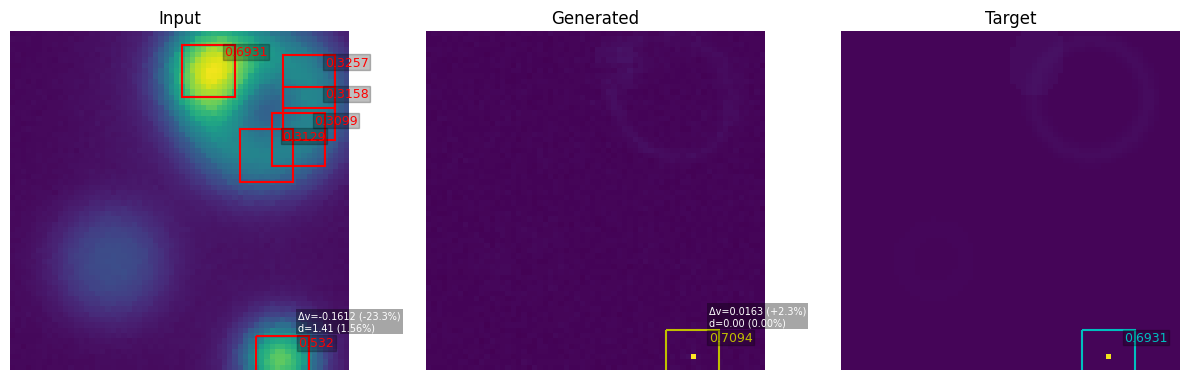

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import maximum_filter, gaussian_filter
from scipy.optimize import linear_sum_assignment

# -------------------------------
# 1) 严格局部极大值 + 自动点源检测
# -------------------------------
def _strict_local_maxima_sorted(img2d: np.ndarray, neighborhood: int = 3, sigma: float | None = None):
    """
    返回严格局部极大值（与8邻域比较，中心像素必须 > 任一邻居），按强度从高到低排序。
    - neighborhood: 奇数（通常 3），决定邻域大小
    - sigma: 可选轻微平滑；单像素点源建议 None 或很小（0.3~0.5）
    """
    assert neighborhood % 2 == 1, "neighborhood must be odd."
    img = img2d.astype(np.float32, copy=False)
    if sigma and sigma > 0:
        img = gaussian_filter(img, sigma=sigma)

    # 8邻域最大值（不包含中心像素本身）
    footprint = np.ones((neighborhood, neighborhood), dtype=bool)
    center = neighborhood // 2
    footprint[center, center] = False  # 排除中心
    neighbor_max = maximum_filter(img, footprint=footprint, mode='nearest')

    # 严格极大值：必须严格大于邻居
    mask = img > neighbor_max
    ys, xs = np.where(mask)
    if ys.size == 0:
        return np.array([]), np.array([]), np.array([])

    vals = img[ys, xs]
    order = np.argsort(vals)[::-1]
    return ys[order], xs[order], vals[order]

def detect_point_sources_auto_v2(
    img2d: np.ndarray,
    intensity_threshold: float = 0.2,   # 硬阈值：候选峰 < 阈值 即停止
    min_distance: int = 6,              # NMS最小间距（像素）
    neighborhood: int = 3,              # 8邻域窗口（奇数，建议3）
    sigma: float | None = None,         # 单像素点源建议 None 或 0.3
):
    """
    从最亮往下选严格局部极大值；一旦下一个候选峰值 < intensity_threshold 就停止。
    返回 [(y, x, value), ...]，按强度降序。
    """
    ys, xs, vals = _strict_local_maxima_sorted(img2d, neighborhood=neighborhood, sigma=sigma)
    selected = []
    for (y, x, v) in zip(ys, xs, vals):
        if v < intensity_threshold:
            break
        if not selected:
            selected.append((int(y), int(x), float(v)))
            continue
        # 简单 NMS（欧氏距离）
        ok = True
        for (yy, xx, _) in selected:
            if (y - yy)**2 + (x - xx)**2 <= (min_distance**2):
                ok = False
                break
        if ok:
            selected.append((int(y), int(x), float(v)))
    return selected

# -------------------------------
# 2) 画框工具
# -------------------------------
def _draw_boxes(ax, centers, box_size=10, color='r', lw=1.5):
    for (y, x, v) in centers:
        half = box_size // 2
        rect = plt.Rectangle((int(x - half), int(y - half)), box_size, box_size, 
                             fill=False, ec=color, lw=lw)
        ax.add_patch(rect)
        ax.text(x + 3, y - 3, f"{v:.4g}", color=color, fontsize=9,
                bbox=dict(facecolor='k', alpha=0.25, pad=1))

def _peaks_str(peaks):
    if not peaks:
        return "None"
    lines = []
    for i, (y, x, v) in enumerate(peaks, start=1):
        lines.append(f"  #{i}: value={v:.6f}, coord=(y={y}, x={x})")
    return "\n" + "\n".join(lines)

def _annotate_errors_on_axes(ax, src_peaks, tgt_peaks, img_shape, color='w', fontsize=9, max_pair_dist=None):
    """
    在 ax 上为 src_peaks 标注其与 target 的 Δvalue（含%）与 dist（含%）。
    使用与输出一致的匈牙利匹配；仅对已匹配的源做标注。
    """
    H, W = img_shape
    diag = (H**2 + W**2)**0.5 if H > 0 and W > 0 else 1.0

    # 重用之前的匹配器
    pairs, _, _ = _match_to_target(src_peaks, tgt_peaks, max_pair_dist=max_pair_dist)

    for (i_s, j_t, dist) in pairs:
        ys, xs, vs = src_peaks[i_s]
        yt, xt, vt = tgt_peaks[j_t]
        v_err = vs - vt
        pct_val  = (100.0 * v_err / vt) if vt != 0 else float("inf")
        pct_dist = 100.0 * dist / diag

        # 标注文本稍微偏移一点，避免和框重叠
        ax.text(
            xs + 3, ys - 6,
            f"Δv={v_err:.4f} ({pct_val:+.1f}%)\n"
            f"d={dist:.2f} ({pct_dist:.2f}%)",
            color=color, fontsize=fontsize,
            bbox=dict(facecolor='black', alpha=0.35, pad=1.5, edgecolor='none')
        )


# -------------------------------
# 3) 一一匹配（匈牙利），并带误差输出
# -------------------------------
def _match_to_target(src_peaks, tgt_peaks, max_pair_dist=None):
    """
    将 src_peaks 与 tgt_peaks 做一对一匹配（最小化空间距离）。
    返回：
      pairs: [(i_src, j_tgt, dist)]  # 已匹配的索引与距离
      unmatched_src: [i, ...]        # 未匹配的 src 索引
      unmatched_tgt: [j, ...]        # 未匹配的 tgt 索引
    max_pair_dist: 若设定（像素），超过该距离的配对会被丢弃为 unmatched。
    """
    if (not src_peaks) or (not tgt_peaks):
        return [], list(range(len(src_peaks))), list(range(len(tgt_peaks)))

    src = np.array([(y, x, v) for (y, x, v) in src_peaks], dtype=float)
    tgt = np.array([(y, x, v) for (y, x, v) in tgt_peaks], dtype=float)

    ns, nt = len(src), len(tgt)
    # 成本矩阵 = 欧氏距离
    C = np.zeros((ns, nt), dtype=float)
    for i in range(ns):
        dy = src[i, 0] - tgt[:, 0]
        dx = src[i, 1] - tgt[:, 1]
        C[i, :] = np.sqrt(dy * dy + dx * dx)

    ri, cj = linear_sum_assignment(C)            # 全局最优一对一
    pairs = []
    used_src, used_tgt = set(), set()
    for i_s, j_t in zip(ri, cj):
        dist = float(C[i_s, j_t])
        if (max_pair_dist is not None) and (dist > max_pair_dist):
            continue
        pairs.append((int(i_s), int(j_t), dist))
        used_src.add(int(i_s)); used_tgt.add(int(j_t))

    unmatched_src = [i for i in range(ns) if i not in used_src]
    unmatched_tgt = [j for j in range(nt) if j not in used_tgt]
    return pairs, unmatched_src, unmatched_tgt

def _peaks_str_matched(src_peaks, tgt_peaks, img_shape=None, max_pair_dist=None):
    """
    将 src 与 target 做匹配后，逐对输出：
      value(src)，坐标src；与 target 的 Δvalue（含百分比）、dist（含百分比）
    并在末尾列出 unmatched 的项。
    """
    H, W = img_shape if img_shape is not None else (1, 1)
    diag = (H**2 + W**2)**0.5 if H > 0 and W > 0 else 1.0

    pairs, um_src, um_tgt = _match_to_target(src_peaks, tgt_peaks, max_pair_dist=max_pair_dist)

    lines = []
    for k, (i_s, j_t, dist) in enumerate(pairs, start=1):
        ys, xs, vs = src_peaks[i_s]
        yt, xt, vt = tgt_peaks[j_t]
        v_err = vs - vt
        pct_val  = (100.0 * v_err / vt) if vt != 0 else float("inf")
        pct_dist = 100.0 * dist / diag
        lines.append(
            f"\n  #{k}: value={vs:.6f}, coord=(y={ys}, x={xs}), "
            f"Δvalue={v_err:.6f} ({pct_val:+.1f}%), "
            f"dist={dist:.3f} ({pct_dist:.2f}%)"
        )

    if um_src:
        ids = ", ".join([f"#{i+1}" for i in um_src])
        lines.append(f"\n  Unmatched src: {ids}")
    if um_tgt:
        ids = ", ".join([f"#{j+1}" for j in um_tgt])
        lines.append(f"\n  Unmatched target: {ids}")

    return "".join(lines) if lines else " None"

def _peaks_str_matched_aligned(src_peaks, tgt_peaks, img_shape=None, max_pair_dist=None):
    """
    输出时按 target 排序对齐：target #1 对应一行，找出匹配到的 src 源并输出 Δvalue/dist。
    """
    H, W = img_shape if img_shape is not None else (1, 1)
    diag = (H**2 + W**2)**0.5 if H > 0 and W > 0 else 1.0

    pairs, um_src, um_tgt = _match_to_target(src_peaks, tgt_peaks, max_pair_dist=max_pair_dist)

    # 建立 target -> src 的映射
    tgt2src = {j_t: (i_s, dist) for (i_s, j_t, dist) in pairs}

    lines = []
    for j_t, (yt, xt, vt) in enumerate(tgt_peaks, start=1):
        if j_t-1 in tgt2src:
            i_s, dist = tgt2src[j_t-1]
            ys, xs, vs = src_peaks[i_s]
            v_err = vs - vt
            pct_val  = (100.0 * v_err / vt) if vt != 0 else float("inf")
            pct_dist = 100.0 * dist / diag
            lines.append(
                f"\n  ↔ Target #{j_t}: src value={vs:.6f}, coord=(y={ys}, x={xs}), "
                f"Δvalue={v_err:.6f} ({pct_val:+.1f}%), "
                f"dist={dist:.3f} ({pct_dist:.2f}%)"
            )
        else:
            lines.append(f"\n  ↔ Target #{j_t}: No matched src")

    if um_src:
        ids = ", ".join([f"#{i+1}" for i in um_src])
        lines.append(f"\n  Unmatched src: {ids}")

    return "".join(lines) if lines else " None"


# -------------------------------
# 4) 主函数：读取、检测、匹配、可视化、打印
# -------------------------------
def analyze_and_show_triplet_auto_v2(
    n: int,
    base_dir: str = "/root/LHAI/images_1000",   # 默认路径
    cmap: str = "viridis",
    intensity_threshold: float = 0.2,          # 阈值
    min_distance: int = 6,
    neighborhood: int = 3,
    sigma: float | None = None,                # 单像素点源=>None 或 0.3
    box_size: int = 10,
    save_png: bool = False,                    # 默认不落盘
    max_pair_dist: float | None = None         # ★ 新增：匹配的最大允许距离（像素）；None 表示不限制
):
    """
    读取第 n 对 input/target/generated 的 .npy，自动检测未知数量的点源（严格局部极大值），
    然后将 Input 与 Gen 分别与 Target 进行全局最优一一匹配（按空间距离），
    打印 Δvalue（含%）与 dist（含%），并可视化框选。
    """
    base = Path(base_dir)
    p_input     = base / "input"     / f"input_{n}.npy"
    p_target    = base / "target"    / f"target_{n}.npy"
    p_generated = base / "generated" / f"generated_{n}.npy"

    inp = np.load(p_input)
    tgt = np.load(p_target)
    gen = np.load(p_generated)

    inp = np.log(inp+1)
    tgt = np.log(tgt+1)
    gen = np.log(gen+1)

    print(inp)

    np.savetxt('test.out', inp, delimiter=',',fmt = '%.2f')
    np.savetxt('tgt.out', tgt, delimiter=',',fmt = '%.2f')

    # 检测峰
    peaks_inp = detect_point_sources_auto_v2(
        inp, intensity_threshold=intensity_threshold, min_distance=min_distance,
        neighborhood=neighborhood, sigma=sigma
    )
    peaks_tgt = detect_point_sources_auto_v2(
        tgt, intensity_threshold=intensity_threshold, min_distance=min_distance,
        neighborhood=neighborhood, sigma=sigma
    )
    peaks_gen = detect_point_sources_auto_v2(
        gen, intensity_threshold=intensity_threshold, min_distance=min_distance,
        neighborhood=neighborhood, sigma=sigma
    )

    print(f"[Input  #{n}] aligned to Target (count={len(peaks_inp)} vs {len(peaks_tgt)}):"
      f"{_peaks_str_matched_aligned(peaks_inp, peaks_tgt, inp.shape, max_pair_dist)}")

    print(f"[Gen    #{n}] aligned to Target (count={len(peaks_gen)} vs {len(peaks_tgt)}):"
          f"{_peaks_str_matched_aligned(peaks_gen,  peaks_tgt, gen.shape, max_pair_dist)}")
    
    print(f"[Target #{n}] count={len(peaks_tgt)} peaks:{_peaks_str(peaks_tgt)}")


    # —— 可视化（统一色标，公平展示）——
    vmin = min(inp.min(), tgt.min(), gen.min())
    vmax = max(inp.max(), tgt.max(), gen.max())

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    im0 = axes[0].imshow(inp, cmap=cmap, vmin=vmin, vmax=vmax); axes[0].set_title("Input");  axes[0].axis("off")
    im1 = axes[1].imshow(gen, cmap=cmap, vmin=vmin, vmax=vmax); axes[1].set_title("Generated"); axes[1].axis("off")
    im2 = axes[2].imshow(tgt, cmap=cmap, vmin=vmin, vmax=vmax); axes[2].set_title("Target"); axes[2].axis("off")

    _draw_boxes(axes[0], peaks_inp, box_size=box_size, color='r')
    _draw_boxes(axes[1], peaks_gen, box_size=box_size, color='y')
    _draw_boxes(axes[2], peaks_tgt, box_size=box_size, color='c')

    # 在 Input/Gen 图上标注相对 Target 的误差（强度与空间）
    _annotate_errors_on_axes(axes[0], peaks_inp, peaks_tgt, inp.shape,  color='w', fontsize=7, max_pair_dist=max_pair_dist)
    _annotate_errors_on_axes(axes[1], peaks_gen, peaks_tgt, gen.shape,  color='w', fontsize=7, max_pair_dist=max_pair_dist)

    plt.tight_layout()

    if save_png:
        out_dir = base / "preview"
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / f"peaks_auto_v2_{n}.png"
        plt.savefig(out_path, dpi=220)
        print(f"✅ Saved: {out_path}")

    plt.show()

analyze_and_show_triplet_auto_v2(

    45,                     # n: 选择第 1 对图像 (input_1.npy, target_1.npy, generated_1.npy)

    intensity_threshold=0.2, # 阈值：检测到的点源强度必须 ≥ 0.2，否则停止继续寻找新的点源

    sigma=None,              # 高斯平滑 σ 值：
                             # None 表示不做平滑（适合检测单像素点源）
                             # 可以设为 0.3 ~ 1.0，在有噪声或点源比较扩展时能更稳健

    min_distance=5,          # 最小间距 (像素)：两个点源之间至少相隔 5 个像素
                             # 用于 NMS 去重，避免同一个源被检测成多个峰

    neighborhood=3,          # 邻域大小：局部极大值的判定窗口（3 表示 3×3，也就是 8 邻域）
                             # 越大 → 越严格，减少误检，但可能漏掉靠得近的源

    save_png=False,           # True  → 结果保存到 /root/LHAI/images_400/preview/

    max_pair_dist=None       # 可选：最大允许配对距离（像素），如 6/8；None 表示不限制
)

In [36]:
# ==========================================
# 批处理：统计前 N 组的平均误差（Input↔Target, Gen↔Target）
# ==========================================
from statistics import mean
import numpy as np

def _collect_pair_errors(src_peaks, tgt_peaks, img_shape, max_pair_dist=None):
    """
    将 src 与 tgt 做匹配，返回该对图像内所有匹配对的误差列表：
      v_err_list:       [Δvalue]（有正负号）
      v_err_abs_list:   [|Δvalue|]
      v_err_pct_list:   [Δvalue / target * 100]（有正负号，target=0 时跳过）
      dist_list:        [欧氏距离（像素）]
      dist_pct_list:    [距离 / 对角线 * 100]
    """
    H, W = img_shape
    diag = (H**2 + W**2)**0.5 if H > 0 and W > 0 else 1.0

    pairs, _, _ = _match_to_target(src_peaks, tgt_peaks, max_pair_dist=max_pair_dist)

    v_err_list, v_err_abs_list, v_err_pct_list = [], [], []
    dist_list, dist_pct_list = [], []

    for (i_s, j_t, dist) in pairs:
        ys, xs, vs = src_peaks[i_s]
        yt, xt, vt = tgt_peaks[j_t]
        v_err = vs - vt
        v_err_list.append(v_err)
        v_err_abs_list.append(abs(v_err))
        if vt != 0:
            v_err_pct_list.append(100.0 * v_err / vt)  # 保留正负号
        # 空间
        dist_list.append(dist)
        dist_pct_list.append(100.0 * dist / diag)

    return v_err_list, v_err_abs_list, v_err_pct_list, dist_list, dist_pct_list


def batch_evaluate_first_N(
    N=100,
    base_dir="/root/LHAI/images_1000",
    intensity_threshold=0.2,
    sigma=None,
    min_distance=5,
    neighborhood=3,
    max_pair_dist=None
):
    base = Path(base_dir)

    # 累计容器（Input↔Target）
    inp_v_err, inp_v_err_abs, inp_v_err_pct = [], [], []
    inp_dist,   inp_dist_pct   = [], []

    # 累计容器（Gen↔Target）
    gen_v_err, gen_v_err_abs, gen_v_err_pct = [], [], []
    gen_dist,   gen_dist_pct   = [], []

    valid_pairs_input = 0   # 统计匹配对数量（可选）
    valid_pairs_gen   = 0

    for n in range(1, N+1):
        p_input     = base / "input"     / f"input_{n}.npy"
        p_target    = base / "target"    / f"target_{n}.npy"
        p_generated = base / "generated" / f"generated_{n}.npy"
        # 文件缺失则跳过
        if not (p_input.exists() and p_target.exists() and p_generated.exists()):
            continue

        inp = np.load(p_input)
        tgt = np.load(p_target)
        gen = np.load(p_generated)

        # 峰值检测（与单图一致）
        peaks_inp = detect_point_sources_auto_v2(
            inp, intensity_threshold=intensity_threshold, min_distance=min_distance,
            neighborhood=neighborhood, sigma=sigma
        )
        peaks_tgt = detect_point_sources_auto_v2(
            tgt, intensity_threshold=intensity_threshold, min_distance=min_distance,
            neighborhood=neighborhood, sigma=sigma
        )
        peaks_gen = detect_point_sources_auto_v2(
            gen, intensity_threshold=intensity_threshold, min_distance=min_distance,
            neighborhood=neighborhood, sigma=sigma
        )

        # Input ↔ Target
        vi, via, vip, di, dip = _collect_pair_errors(peaks_inp, peaks_tgt, inp.shape, max_pair_dist)
        inp_v_err.extend(vi)
        inp_v_err_abs.extend(via)
        inp_v_err_pct.extend(vip)
        inp_dist.extend(di)
        inp_dist_pct.extend(dip)
        valid_pairs_input += len(di)

        # Gen ↔ Target
        vg, vga, vgp, dg, dgp = _collect_pair_errors(peaks_gen, peaks_tgt, gen.shape, max_pair_dist)
        gen_v_err.extend(vg)
        gen_v_err_abs.extend(vga)
        gen_v_err_pct.extend(vgp)
        gen_dist.extend(dg)
        gen_dist_pct.extend(dgp)
        valid_pairs_gen += len(dg)

    def _safe_mean(lst):
        return float(mean(lst)) if len(lst) > 0 else float("nan")

    summary = {
        "Input_vs_Target": {
            "num_matched_pairs": valid_pairs_input,
            "mean_Δvalue": _safe_mean(inp_v_err),
            "mean_|Δvalue|": _safe_mean(inp_v_err_abs),
            "mean_Δvalue_%": _safe_mean(inp_v_err_pct),
            "mean_dist(px)": _safe_mean(inp_dist),
            "mean_dist_%diag": _safe_mean(inp_dist_pct),
        },
        "Gen_vs_Target": {
            "num_matched_pairs": valid_pairs_gen,
            "mean_Δvalue": _safe_mean(gen_v_err),
            "mean_|Δvalue|": _safe_mean(gen_v_err_abs),
            "mean_Δvalue_%": _safe_mean(gen_v_err_pct),
            "mean_dist(px)": _safe_mean(gen_dist),
            "mean_dist_%diag": _safe_mean(gen_dist_pct),
        }
    }
    return summary

# ==== 运行批处理并打印结果 ====
summary = batch_evaluate_first_N(
    N=2000,
    base_dir="/root/LHAI/images_400",
    intensity_threshold=0.2,
    sigma=None,
    min_distance=5,
    neighborhood=3,
    max_pair_dist=None  # 可设像素阈值（如 6/8）；None 表示不限制
)

print("\n=== Averages over first 2000 triplets (matched pairs only) ===")
for k, v in summary.items():
    print(f"\n[{k}]")
    for mk, mv in v.items():
        if isinstance(mv, float):
            print(f"  {mk}: {mv:.6f}")
        else:
            print(f"  {mk}: {mv}")



=== Averages over first 2000 triplets (matched pairs only) ===

[Input_vs_Target]
  num_matched_pairs: 4117
  mean_Δvalue: -0.022929
  mean_|Δvalue|: 0.136988
  mean_Δvalue_%: 6.625631
  mean_dist(px): 3.889223
  mean_dist_%diag: 4.297025

[Gen_vs_Target]
  num_matched_pairs: 4384
  mean_Δvalue: -0.053763
  mean_|Δvalue|: 0.132370
  mean_Δvalue_%: -3.125874
  mean_dist(px): 2.442847
  mean_dist_%diag: 2.698990
